# Multilayer Network Creation 

We create a network with 5 layers, some of each changing over time, using publicly available graph datasets or a syntethic generation of graphs based on real aggregated data collected through official sources.

In particular we are going to create a multi-layer temporal graph whit the following social layers:
- hospital dynamic layer: from a real temporal graph, readapted for the case, representing contects between medical staff and patients of an hoapital
- workplace dynamic layer: representing temporal contacts between employess of same companies, from a real temporal dataset
- school static layer: daily contacts between students of the same class/school, inspired by real data
- household static layer: layer of the families, distributed by number of components according to ISTAT data
- random dynamic layer: containing links randomly generated every day, representing occasional meeting between people not necessarly related (in means of transport, restaurants, supermarkets,..)


In [1]:
# Basic math libraries
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math
from matplotlib import pyplot as plt
import pickle
from matplotlib.colors import ListedColormap

# Matrix eigendecomposition
import numpy.linalg as lg
import scipy.linalg as slg

# Networks and Graphs
import networkx as nx
import dynetx as dn

# Random data generation
import itertools
import random
from collections import Counter
from random import randint
from itertools import chain

# Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

%load_ext autoreload
%autoreload 2
import time

To use the data provided by ISTAT and the dynamic datasets available online (hospital contacts, workplace contacts) we create a network representing a city area of N = 5000 people and maintaining ISTAT proportion of employment and family composition as:
- 40% workers, and in particular:
    - 1% of hospital workers
    - 75% employed
    - 25% self-employed
- 17% students
- 43% pensioners, unemployed people and pre-school age children

- 31.5% people living alone
- 27% families of 2 components
- 20% families of 3 components
- and so on (see each layer section for details)

Some additional parameters are taken from research results, saying that:
- after COVID-19 infection an immunization is granted for at least 2 months
- in normal situations, infected people is contagious for 10-14 days

In [2]:
# SET CRITICAL NUMBERS

N = 500 #5000                                             # number of nodes
S = 5                                                # number of layers (dyn + static)
infection_threshold = 0.8                            # signal value over which a person is considered sick
max_sickness_duration = 10                           # days of maximum duration of the illness
min_immunization_duration = 60                       # days of immunization after having taken the virus

# # REAL COVID DATA (24.02.2020 to 13.01.2021)
# La_Spezia_cases = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 11, 15, 15, 19, 26, 37, 52, 60, 60, 65, 83, 88, 90, 94, 99, 110, 104, 137, 149, 213, 234, 233, 234, 248, 245, 250, 323, 341, 445, 450, 463, 605, 619, 629, 629, 670, 670, 660, 696, 720, 725, 741, 767, 777, 788, 793, 803, 809, 813, 815, 823, 822, 825, 829, 835, 845, 850, 861, 865, 868, 871, 877, 886, 889, 891, 895, 896, 899, 900, 901, 902, 903, 899, 901, 896, 896, 897, 897, 897, 897, 897, 893, 897, 892, 892, 897, 892, 894, 895, 895, 896, 896, 897, 897, 897, 896, 896, 896, 896, 897, 897, 898, 897, 897, 897, 897, 896, 896, 854, 854, 855, 855, 855, 858, 860, 860, 860, 860, 861, 862, 861, 862, 863, 863, 866, 866, 866, 867, 867, 867, 867, 867, 867, 868, 868, 868, 868, 869, 869, 870, 870, 872, 872, 875, 878, 878, 878, 879, 879, 879, 879, 879, 880, 880, 880, 880, 881, 883, 895, 898, 900, 900, 902, 906, 911, 918, 919, 925, 936, 947, 952, 968, 979, 1004, 1026, 1057, 1087, 1098, 1121, 1127, 1146, 1189, 1262, 1309, 1334, 1367, 1459, 1512, 1581, 1629, 1672, 1753, 1784, 1792, 1878, 1911, 1942, 1962, 2019, 2042, 2093, 2114, 2137, 2152, 2180, 2196, 2204, 2232, 2254, 2273, 2290, 2312, 2326, 2341, 2357, 2387, 2417, 2443, 2468, 2485, 2518, 2536, 2566, 2604, 2671, 2709, 2736, 2783, 2837, 2881, 2972, 3044, 3138, 3265, 3352, 3498, 3580, 3764, 3899, 3980, 4036, 4133, 4286, 4458, 4607, 4749, 4795, 4905, 5037, 5149, 5309, 5455, 5588, 5639, 5674, 5865, 5976, 6059, 6173, 6302, 6335, 6398, 6484, 6530, 6654, 6731, 6798, 6819, 6854, 6918, 7003, 7057, 7095, 7146, 7154, 7191, 7214, 7301, 7369, 7414, 7462, 7485, 7531, 7611, 7666, 7700, 7740, 7787, 7790, 7811, 7862, 7922, 7988, 8002, 8020, 8040, 8117, 8171, 8229, 8308, 8331, 8401, 8416, 8458, 8494, 8577, 8622, 8698, 8762, 8773, 8810, ]

# # adjust T and COVID DATA (4.03.2020 to 2.04.2020)
# La_Spezia_cases = La_Spezia_cases[9:]                # remove first days wih only 1 case
# T = len([x for x in La_Spezia_cases if x<N])         # T as max n. of days the graph can support
# La_Spezia_cases = La_Spezia_cases[:T]                # slice and take T days of cases


# calculation of T depending as LCM of the ones of the loaded datasets and the week lenght
T_hospital_dataset = 4
T_workplace_dataset = 14
LCM = int((T_hospital_dataset*T_workplace_dataset)/math.gcd(T_hospital_dataset,T_workplace_dataset))
if LCM%7 == 0:
    T = LCM
else:
    T = LCM*7


print("T =", T, "  number of timeshots")
print("N =", N, "  number of nodes of the graph")
print("S =", S, "  number of layers of the multigraph")

T = 28   number of timeshots
N = 500   number of nodes of the graph
S = 5   number of layers of the multigraph


We represent the layers of the multi-layer temporal network as NxN laplacian matrices, each one for each layer and for each timestamp $\{L_{t}^s\}_{t=0,..,T, \; s=1,..,S}$. Same layer of the network is static (like the household one, considering that families don't change over time) while others are dynamic (like the workplace, and random one) for this reagion can be useful in phase of creation to distinguish between 

In [3]:
L_dynamic = []
L_static = []

Where L_dynamic is a collection of time series of laplacians, each one corresponding to one dynamic layer (hospital, workplace, random), and L_static is a collection of static laplacians each one for each static layer (school, household). 

The final laplacian L that is taken as input by the ML model, is a 4-dimentional matrix NxNxSxT given by the concatenation of L_dynamic and L_static.

## Dynamic layers

### Useful functions

In this section we define Mapping Functions to map the node numbers provided by different data sources (possibly "ugly" and unrelated between sources) into uniform numbers (0,1,2,3...):

- "Generate_mappings" takes 2 lists and return a dictionary that put the 2 in relation, eventually on both directions 
     like {3,6} and {6, 3}. If the second list is nor provided, 0,1,2...N will be used.
- "Apply_mapping" apply the dictionary calculated before, to a list given as input and returned wit the values replaced.
- "Normalize_hospital_files" modifies the 2 files containing hospital data (the .edges dynamic graph and the .cvs with 
     hospital roles) chaning the nodeID with numbers from 0 to N. Using the 2 above mapping functions.
     
And plot functions to plot dynamic and static graphs:

- "print_static_network"
- "print_dynamic_network"

In [4]:
# mapping functions

def generate_mapping(list_1, list_2 = [], bijection=False):  
    
    if len(list_2) == 0:
        list_2 = list(range(len(list_1)))       
    mapping = []
    for i in range(min(len(list_1),len(list_2))):
        mapping.append((list_1[i], list_2[i]))
        if bijection:
            mapping.append((list_2[i], list_1[i]))
    mapping = dict(mapping)
    return mapping
          
def apply_mapping(input_list, mapping): 
    
    normalized_list = []
    for elem in input_list:
        if type(elem)==tuple:
            normalized_list.append((mapping.get(elem[0], elem[0]), mapping.get(elem[1], elem[1])))
        if type(elem)==int :
            normalized_list.append(mapping.get(elem))
    return normalized_list

def normalize_files(file1_input_path, file1_output_path, file2_input_path=None, file2_output_path=None):
    
    # import the files
    file1 = pd.read_csv(file1_input_path, header=None, names=['Node1','Node2','time']) 
    if file2_input_path is not None:
        file2 = pd.read_csv(file2_input_path, header=None, names=['Node','role_bool','role'])   
    
    # define a mapping, excluding hospital staff from working or studying elsewhere
    total_nodes = list(set(list(file1['Node1'])+list(file1['Node2'])))
    total_nodes.sort()
    if "hospital" in file1_input_path:
        mapping = generate_mapping(total_nodes)    
    else:
        hospital_staff = (hospital_roles[hospital_roles['role_bool'] == 0]['Node']).tolist()
        list_free_nodes = [x for x in range(N) if x > max(hospital_staff)]
        mapping = generate_mapping(total_nodes, list_free_nodes)
                    
    # apply the mapping to the nodeIDs columns
    file1_normalized = file1[['Node1','Node2']].replace(mapping)
    file1_normalized[['time']] = file1[['time']]
    if file2_input_path is not None:
        file2_normalized = file2[['Node']].replace(mapping)
        file2_normalized[['role_bool','role']] = file2[['role_bool','role']]
      
    # export the new files
    file1_normalized = file1.replace(mapping)
    file1_normalized.to_csv(file1_output_path, sep=',', header=False, index=False)
    if file2_input_path is not None:
        file2_normalized = file2.replace(mapping)
        file2_normalized.to_csv(file2_output_path, sep=',', header=False, index=False)

In [5]:
# plot functions

def print_static_network(L, remove_isolated = False, layer_name = '', node_color='b', pos=None):
    graph_to_display = nx.from_numpy_matrix(-L + np.diag(np.diag(L)))
    if pos is None:
        pos=nx.spring_layout(graph_to_display)
    if remove_isolated == True:
            graph_to_display.remove_nodes_from(list(nx.isolates(graph_to_display)))
    
    plt.figure(figsize=(7.5, 5))
    nx.draw_networkx_nodes(graph_to_display, pos=pos, node_size=10, node_color=node_color)
    nx.draw_networkx_edges(graph_to_display, pos=pos, width=0.3, edge_color='grey')
    plt.title(layer_name+" static layer", fontsize=13)
    plt.show()
    
    
def print_dynamic_network(L_dynamic, n_snapshots_to_print, remove_isolated = False, layer_name = '', node_color='b', pos=None):
    days_to_display = [round( (T)*i/(n_snapshots_to_print-1)) for i in range(0, n_snapshots_to_print-1)] + [T-1]
    days_to_display.sort()
    
    plt.figure(figsize=(7.5, 5))
    fig, axes = plt.subplots(nrows=1, ncols=len(days_to_display), figsize = [18, 4])
    ax = axes.flatten()   
    for idx, val in enumerate(days_to_display):
        l = L_dynamic[val]
        graph_to_display = nx.from_numpy_matrix(-l + np.diag(np.diag(l)))
#         emap = ListedColormap([(0,0,0)])
        if pos is None:  # idx == 0 and           
            pos=nx.spring_layout(graph_to_display)   # pos=nx.kamada_kawai_layout(graph_to_display)   
        if remove_isolated == True:
            graph_to_display.remove_nodes_from(list(nx.isolates(graph_to_display)))
        nx.draw_networkx_nodes(graph_to_display, pos=pos, node_size=10, node_color=node_color, ax=ax[idx]) # cmap=MyCmap,
        nx.draw_networkx_edges(graph_to_display, pos=pos, width=0.3, edge_color='grey', ax=ax[idx])
        ax[idx].set_title(layer_name+" contacts at day: "+str(val), fontsize=13)
    plt.show()

In [6]:
# import position to print the graph always in the same way

# pos = None
layout = "spring_layout"
pos = np.load("datasets/nodes position for plot/position_network_" + layout +".npy", allow_pickle=True).item()   

### Hospital layer

This dataset contains the temporal network of contacts happening
- between patients, 
- between patients and health-care workers (HCWs) 
- among HCWs 
in a hospital ward in Lyon (France) during a typical week of work: from Monday 6/12/2010 to Friday 10/12/2010. Here the link to the dataset: http://www.sociopatterns.org/datasets/hospital-ward-dynamic-contact-network/ .

Contact events were measured with a spatial resolution of about 1.5 meters and a temporal resolution of 20 seconds. The study included 46 HCWs and 29 patients and lasted for 4 days and 4 nights. 14,037 contacts were recorded overall, 94.1% of which during daytime. By construction, the number of 46 hospital staff corresponds to 1% of our N=4600 nodes, as we wanted per ISTAT percentage data.

In [7]:
# Normalize into 0,..,N the nodeIDs into both hospital files and rewrite them in the folder

normalize_files("datasets/inputs/ia-hospital-ward-proximity.edges", "datasets/outputs/hospital_contacts_normalized.edges", \
                "datasets/inputs/roles_Hospital.csv", "datasets/outputs/hospital_roles_normalized.csv")

# Import the files

hospital_contacts_4days = dn.read_snapshots("datasets/outputs/hospital_contacts_normalized.edges", directed= False, delimiter=',', nodetype=int, timestamptype=int)
hospital_roles = pd.read_csv("datasets/outputs/hospital_roles_normalized.csv", header=None, names=['Node','role_bool','role']) 


# Print info

print("The timestamps in the dynamic graph file cover", hospital_contacts_4days.temporal_snapshots_ids()[-1], "seconds, "
      "corresponding to", hospital_contacts_4days.temporal_snapshots_ids()[-1]/(24*60*60), "days.")
print("\nThe structure of the roles file is:")
hospital_roles.head(5)

The timestamps in the dynamic graph file cover 347640 seconds, corresponding to 4.023611111111111 days.

The structure of the roles file is:


,Node,role_bool,role
0,0,0,ADM
1,1,0,NUR
2,2,0,NUR
3,3,0,NUR
4,4,0,NUR


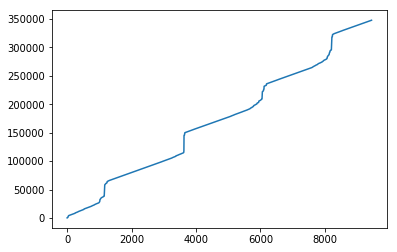

In [8]:
plt.plot(hospital_contacts_4days.temporal_snapshots_ids())

In [9]:
# temporal slicing function (convert dataset in minuts into dataset in days)
  
def slice_dyngraph_hospital(graph_path, n_snapshots, n_snapshots_file, temporal_unit):    
    
    # initializations
    dyn_laplacian = []
    nodes_hospital_staff = (hospital_roles[hospital_roles['role_bool'] == 0]['Node']).tolist()
    
    for t in range(n_snapshots):
           
        if t==0:
            
            # import network
            hospital_contacts_4days_graph = dn.read_snapshots(graph_path, directed= False, delimiter=',', nodetype=int, timestamptype=int)
            hospital_contacts_4days_CSV = pd.read_csv(graph_path, header=None, names=['Node1','Node2','time']) 
            
        if t%n_snapshots_file==0 and t>0:

            # define a mapping to shuffle hospital patients every 4 days
            patients_4days = [x for x in hospital_contacts_4days_graph.nodes() if x not in nodes_hospital_staff]
            non_patients_4days = [x for x in range(N) if x not in hospital_contacts_4days_graph.nodes()]                  
            nodes_to_dismiss = random.sample(patients_4days, 25)
            nodes_to_hospitalize = random.sample(non_patients_4days, 25)
            mapping_patients_4days = generate_mapping(nodes_to_dismiss, nodes_to_hospitalize, bijection = True)   
            
            # update the .edges file and re-import the nextwork
            hospital_contacts_4days_CSV[['Node1','Node2']] = hospital_contacts_4days_CSV[['Node1','Node2']].replace(mapping_patients_4days)
            hospital_contacts_4days_CSV.to_csv(graph_path.split('.')[0]+"_shuffle_temp."+graph_path.split('.')[1], sep=',', header=False, index=False)
            hospital_contacts_4days_graph = dn.read_snapshots(graph_path.split('.')[0]+"_shuffle_temp."+graph_path.split('.')[1], directed= False, delimiter=',', nodetype=int, timestamptype=int)            

        # define slicing time variables
        i = t % n_snapshots_file
        t_from = i*temporal_unit
        t_to = (i+1)*temporal_unit
        
        # slice and create the graph of the day
        day_graph = hospital_contacts_4days_graph.time_slice(t_from, t_to)
        day_graph_nodes = day_graph.nodes()
              
        # Add to it isolated nodes to cover all the population   
        for node in [x for x in range(N) if x not in day_graph_nodes]:  
            day_graph.add_node(node)
        
        # Append the daily graph laplacian to the list of temporal laplacians
        day_laplacian = nx.linalg.laplacianmatrix.laplacian_matrix(day_graph, nodelist=list(range(N)))
        dyn_laplacian.append(np.asarray(day_laplacian.todense()))
        
    return dyn_laplacian

In [10]:
# Slice the input graph in units of 1 day, and extend to T days repeating the dataset but shuffling the patients between 
# the whole population 

seconds_per_day = 24*60*60
T_file = round(hospital_contacts_4days.temporal_snapshots_ids()[-1]/(seconds_per_day))

print("The input temporal graph is sliced in ", T_file, " parts, each one of temporal lenght ", seconds_per_day, " seconds, corresponing to 1 day")
L_dynamic_hospital = slice_dyngraph_hospital(graph_path="datasets/outputs/hospital_contacts_normalized.edges", n_snapshots=T, n_snapshots_file=T_file, temporal_unit=seconds_per_day)

The input temporal graph is sliced in  4  parts, each one of temporal lenght  86400  seconds, corresponing to 1 day


/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 540x360 with 0 Axes>

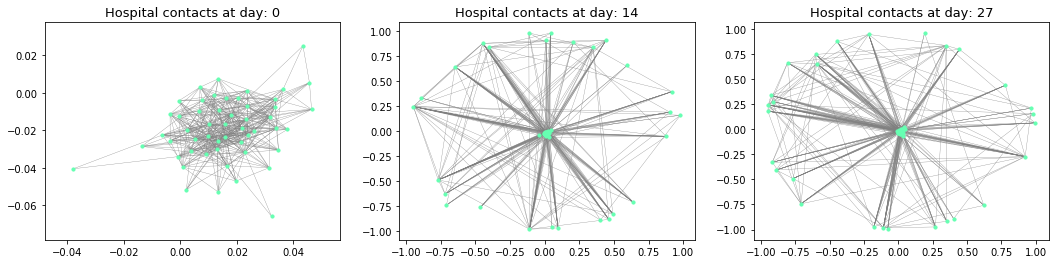

/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 540x360 with 0 Axes>

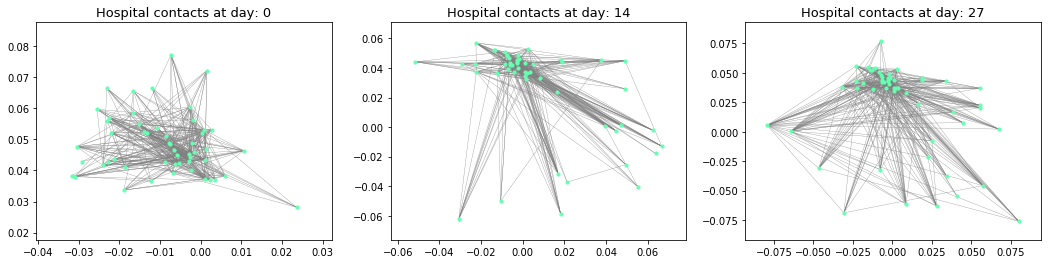

In [11]:
# Visualization of the layer with its proper graphical representation and with the global one

# clustered visualization
n_snapshots_to_print = 3
print_dynamic_network(L_dynamic_hospital, n_snapshots_to_print, remove_isolated = True, layer_name = 'Hospital', node_color = '#66FFB2', pos=None)

# global representation (common to all layers to be stakable)
print_dynamic_network(L_dynamic_hospital, n_snapshots_to_print, remove_isolated = True, layer_name = 'Hospital', node_color = '#66FFB2', pos=pos)

In [12]:
# Append to the dynamic laplacian

L_dynamic.append(L_dynamic_hospital)

### Workplace layer

By ISTAT information, among the 40% of italian workers , 75 per cent are employees (corresponding to 30% of N) while 25 per cent are self-employed workers. While self-employees can be considered as isolated nodes in the workplace layer, the empoloyees can be represented in groups of offices, each one dynamically interconnected day by day. The data of the typical daily connections inside an office are available online at: http://www.sociopatterns.org/datasets/test/ . 

This dataset contains contacts between 92 colleagues of the same office during a time of 11 working days (that with a bit of change we extend to 2 weeks). The structure is similar to the hospital dataset, and we reproduce it many times to cover the right percentage of employees for a population of N elements.

In [13]:
employees_perc_ISTAT = 0.30
employees_office_db = 92
employees = round(N*employees_perc_ISTAT/employees_office_db)*employees_office_db

print("Employees in dynamic relationship: ", employees, " in ", round(N*employees_perc_ISTAT/employees_office_db) , " offices of 92 people each")

Employees in dynamic relationship:  184  in  2  offices of 92 people each


The timestamps in the dynamic graph file cover 1016440 seconds, corresponding to 11.764351851851853 days.


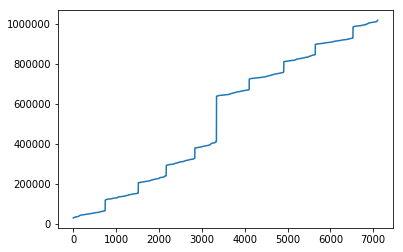

In [14]:
# Normalize into 0,..,N the nodeIDs of the source workplace file and write them in a new file

normalize_files("datasets/inputs/ia-workplace-contacts.edges", "datasets/outputs/workplace_normalized.edges")


# Import the file

workplace_contacts_11days = dn.read_snapshots("datasets/outputs/workplace_normalized.edges", directed= False, delimiter=',', nodetype=int, timestamptype=int)

print("The timestamps in the dynamic graph file cover", workplace_contacts_11days.temporal_snapshots_ids()[-1], "seconds, "
      "corresponding to", workplace_contacts_11days.temporal_snapshots_ids()[-1]/(24*60*60), "days.")
plt.plot(workplace_contacts_11days.temporal_snapshots_ids())

Duplicate many times the dataset describing 1 office, to describe many offices in the area

In [15]:
def duplicate_file_content(file_input_path, file_output_path, len_file, num_duplicates = 1):
    
    # import the file
    file = pd.read_csv(file_input_path, header=None, names=['Node1','Node2','time']) 
    
    # inizialize the output duplicated file
    file_dupl = file
    
    # add for any loop the next number of nodes
    for i in range(num_duplicates-1):
        auxiliary_df = pd.DataFrame()
        auxiliary_df['Node1'] = file['Node1'] + len_file*i
        auxiliary_df['Node2'] = file['Node2'] + len_file*i
        auxiliary_df['time'] = file['time']
        file_dupl = pd.concat([file_dupl, auxiliary_df], ignore_index=True)  
     
    # reorder to have timestamps in decreasing order
    file_dupl.sort_values(by='time', inplace=True, ignore_index=True)
    
    # create the new file
    file_dupl.to_csv(file_output_path, sep=',', header=False, index=False)

In [17]:
# Extend from 1 office of 92 employees to 15 offices (buildings) of 92 employees

# Notice that since the hospital IDS are enumerated until 70 and the offices are of 92 people, there is no need to worry 
# about indexes once already for the first timestamp we avoided the doctors IDs (during normalization)

nodes_hospital_staff = (hospital_roles[hospital_roles['role_bool'] == 0]['Node']).tolist()
print("The doctors working in the hospitals are 46 and their IDs goes from 0 to ", max(nodes_hospital_staff), " so we slide the workers ID from 70 on.")


# Duplicate file content 15 times to reach the right number of employees

num_dupl = round(employees/employees_office_db)
duplicate_file_content(file_input_path="datasets/outputs/workplace_normalized.edges", file_output_path="datasets/outputs/workplace_duplicated.edges", len_file=employees_office_db, num_duplicates = num_dupl)

The doctors working in the hospitals are 46 and their IDs goes from 0 to  70  so we slide the workers ID from 70 on.


Repeat prediodically the dynamics of the graph to cover all the timestamps required 

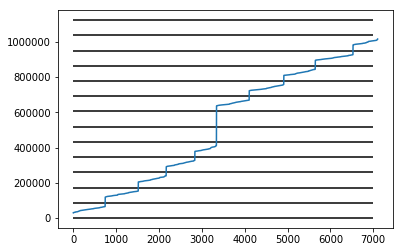

In [18]:
slicing = [workplace_contacts_11days.temporal_snapshots_ids()[0] - 8*60*60 + 24*60*60*i for i in range(14)] 
plt.plot(workplace_contacts_11days.temporal_snapshots_ids())
plt.hlines(slicing , 0, 7000)

In [19]:
# slicing function
  
def slice_dyngraph_workplace(graph_path, n_snapshots, n_snapshots_file, temporal_unit):    
    
    # import network
    workplace_contacts_11days_graph = dn.read_snapshots(graph_path, directed= False, delimiter=',', nodetype=int, timestamptype=int)       
    dyn_laplacian = []
    
    for t in range(n_snapshots):

        # define slicing time variables
        i = t % n_snapshots_file
        t_from = i*temporal_unit - 8*60*60       # consider day starting 8 hours before the office entrance 
        t_to = (i+1)*temporal_unit  - 8*60*60
        
        # slice and create the graph of the day
        day_graph = workplace_contacts_11days_graph.time_slice(t_from, t_to)
        day_graph_nodes = day_graph.nodes()
                    
        # Add to it isolated nodes to cover all the population   
        for node in [x for x in range(N) if x not in day_graph_nodes]:  
            day_graph.add_node(node)
        
        # Append the daily graph laplacian to the list of temporal laplacians
        day_laplacian = nx.linalg.laplacianmatrix.laplacian_matrix(day_graph, nodelist=list(range(N)))
        dyn_laplacian.append(np.asarray(day_laplacian.todense()))
        
    return dyn_laplacian

In [20]:
# Slice the input graph representing only 2 working weeks into daily graphs, and periodically repeate them until T days

seconds_per_day = 24*60*60
T_file = 14 #round(workplace_contacts_11days.temporal_snapshots_ids()[-1]/(seconds_per_day))
print("The input temporal graph is sliced in ", T_file, " parts, each one of temporal lenght ", seconds_per_day, " seconds, corresponing to 1 day")

L_dynamic_workplace = slice_dyngraph_workplace(graph_path="datasets/outputs/workplace_duplicated.edges", n_snapshots=T, n_snapshots_file=T_file, temporal_unit=seconds_per_day)

The input temporal graph is sliced in  14  parts, each one of temporal lenght  86400  seconds, corresponing to 1 day


/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 540x360 with 0 Axes>

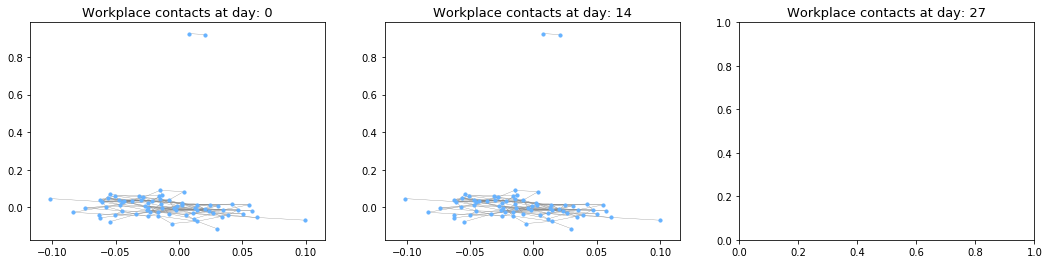

/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 540x360 with 0 Axes>

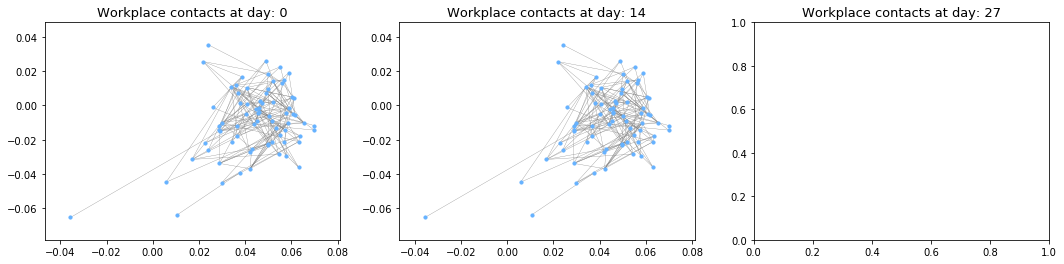

In [21]:
# Visualization of the layer with its proper graphical representation and with the global one

# clustered visualization
n_snapshots_to_print = 3
print_dynamic_network(L_dynamic_workplace, n_snapshots_to_print, remove_isolated=True, layer_name = 'Workplace', node_color = '#66B2FF', pos=None)


# global representation (common to all layers to be stakable)
print_dynamic_network(L_dynamic_workplace, n_snapshots_to_print, remove_isolated=True, layer_name = 'Workplace', node_color = '#66B2FF', pos=pos)

In [22]:
# Append to the dynamic laplacian

L_dynamic.append(L_dynamic_workplace)

### Random Contacts layer

In [23]:
def generate_random_layer(max_number_of_daily_random_contacts):
    
    dyn_laplacian = []

    for t in range(T):
    
            # define empty daily graph
            day_G = nx.Graph()
            
            # pick a random number (max) of links for each person each day:
            for n in range(N):
                number_of_daily_random_contacts = random.randint(0, max_number_of_daily_random_contacts)
                admitted_population = [i for i in range(N) if i != n]
                daily_random_contacts = random.sample(admitted_population, number_of_daily_random_contacts) 
                list_of_edges = [(n, k) for k in daily_random_contacts]
                
                # Add adges to the graph
                day_G.add_edges_from(list_of_edges)
            
            # Add isolated nodes to cover all the population   
            for node in [x for x in range(N) if x not in day_G.nodes()]:  
                day_G.add_node(node)
            
            # Append the daily graph laplacian to the list of temporal laplacians
            day_laplacian = nx.linalg.laplacianmatrix.laplacian_matrix(day_G, nodelist=list(range(N)))
            dyn_laplacian.append(np.asarray(day_laplacian.todense()))
    return dyn_laplacian

In [24]:
# Generate random layer

max_number_of_daily_random_contacts = 2    #(caused by the single node. Other contacts can happen by other nodes)
L_dynamic_random = generate_random_layer(max_number_of_daily_random_contacts)

/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 540x360 with 0 Axes>

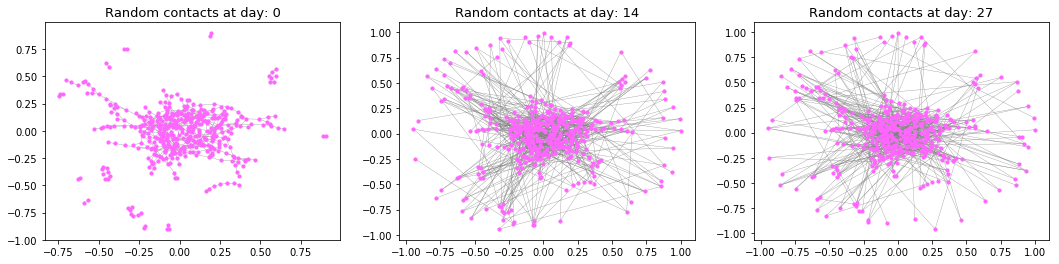

/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 540x360 with 0 Axes>

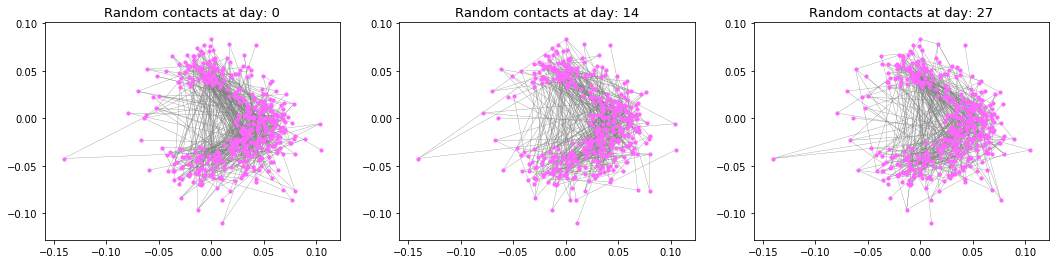

In [25]:
# Visualization of the layer with its proper graphical representation and with the global one

# clustered visualization
n_snapshots_to_print = 3
print_dynamic_network(L_dynamic_random, n_snapshots_to_print, remove_isolated=True, layer_name = 'Random', node_color = '#FF66FF', pos=None)

# global representation (L_dynamic_random to all layers to be stakable)
print_dynamic_network(L_dynamic_random, n_snapshots_to_print, remove_isolated=True, layer_name = 'Random', node_color = '#FF66FF', pos=pos)

In [26]:
# Append to the dynamic laplacian

L_dynamic.append(L_dynamic_random)

## Semi-dynamic layers

In [27]:
# functions to generate the SBM input probabilities

def create_equal_blocks(N, K, S):
    blocks_list = []
#     print( "SBM Blocks to cluster:")         
    for s in range(S):
        k = K[s]
        n = N[s]
        if n-k*round(n/k)==0 :
            blocks = np.zeros(k)+ round(n/k)
        else:
            blocks = np.zeros(k)+ round(n/k)
            blocks[-1] = blocks[-1] + n-k*round(n/k)
        layer_block = [ int(x) for x in blocks ]
        blocks_list.append( layer_block  )
#         print( "block_"+str(s)+":", layer_block)
    return blocks_list


def create_equal_probs(K, S, internal_probs = [None for s in range(S)], external_probs = [None for s in range(S)]):
    probs_list =  []
#     print( "\nSBM link probabilities:")
    for s in range(S):
        if internal_probs[s] is None:
            internal_probs[s] = round(random.uniform(0.8, 1),2)
        if external_probs[s] is None:
            external_probs[s] = round(random.uniform(0.01, 0.3),2)
        layer_probs = np.diag(np.zeros(K[s]) + internal_probs[s]-external_probs[s]) + external_probs[s]
        probs_list.append( layer_probs.tolist() )
#         print( "prob_"+str(s)+":", layer_probs)
    return probs_list

### School layer

This layer is not entirely static, because we keep it with certain (fixed) links during the week days, and without links during the weekend. The week days contacts are calculated taking into account the scholar structure, divided by schools (ages) and classes. 

From ISTAT data about italian students in 2019 http://dati.istat.it/Index.aspx?QueryId=36852 e http://dati.istat.it/Index.aspx?QueryId=32015 we get the following real numbers:
- university      1654616
- high school     2690676
- middle school   1725037
- primary school  2713373
- kindergarten    1450793

from which, in proportion (approximated to integer) we are going to create the following groups with different connection properties:
- 1 university     , where classes are interconnected with strenght 0.2 and extraconnected with 0.05
- 1 high school    , where classes are interconnected with strenght 0.3 and extraconnected with 0.05
- 1 middle school  , where classes are interconnected with strenght 0.4 and extraconnected with 0.01
- 1 primary school , where classes are interconnected with strenght 0.5 and extraconnected with 0.01
- 1 kindergarten   , where classes are interconnected with strenght 0.6 and extraconnected with 0.01

classes count around 25 students each, and calculations are adjusted to work with integer numbers of students.

In [37]:
schools = ["university", "high school", "middle school", "primary school", "kindergarten"]
ISTAT_n_of_students = [1654616, 2690676, 1725037, 2713373, 1450793]
avg_n_of_students_per_class = 23
italian_population = 60*pow(10,6)

proportional_n_of_students = [round(x*N/italian_population) for x in ISTAT_n_of_students]
n_of_schools = len(schools)
n_of_classes = [round(x/avg_n_of_students_per_class) for x in proportional_n_of_students]
n_of_students = [x*avg_n_of_students_per_class for x in n_of_classes]

print("total numer of students", sum(n_of_students), n_of_classes)

total numer of students 115 [1, 1, 1, 1, 1]


In [38]:
internal_probs = [0.2, 0.3, 0.4, 0.5, 0.6] 
external_probs = [0.05, 0.05, 0.01, 0.01, 0.01]
alpha = 0.0001  # regularization parameter

blocks = create_equal_blocks(n_of_students, n_of_classes, n_of_schools)
probs = create_equal_probs(n_of_classes, n_of_schools, internal_probs, external_probs)

In [39]:
# creation of the synthetic static layer of schools, taking into account different kinds of contracts in different schools

for idx, s in enumerate(schools):
    print(s)
    gt = nx.stochastic_block_model(blocks[idx], probs[idx], seed = 100)
    lt = nx.laplacian_matrix(gt,range(len(gt)))
    lt = np.array(lt.todense())                   # convert to non-sparse matrix
    if idx>0: 
        block = scipy.linalg.block_diag(lt_saved, lt)
        lt_saved =  block
    else: 
        lt_saved = lt

university
high school
middle school
primary school
kindergarten


In [45]:
# remapping of the students indices to not overlap with the workers (translation of the SBM matrix)

workers_max_index = min(workplace_contacts_11days.nodes()) + num_dupl*92
zeros_workers = np.zeros((workers_max_index, workers_max_index), dtype='int32')
L_schools_temp = scipy.linalg.block_diag(zeros_workers, block)


# reach the size of NxN matrix

missing_size = N - L_schools_temp.shape[0]
zeros_others = np.zeros((missing_size, missing_size), dtype='int32')
L_schools = scipy.linalg.block_diag(L_schools_temp, zeros_others)

In [46]:
# add weekends without school connections

# create weekend epmty graph
weekend_school = nx.Graph()
weekend_school.add_nodes_from(list(range(N)))

L_weekend_school = nx.laplacian_matrix(weekend_school,range(len(weekend_school.nodes())))
L_weekend_school = np.array(L_weekend_school.todense())

# create the week with 5 days of school and 2 of empty graph
L_week_school = [L_schools]*5 + [L_weekend_school]*2

# periodically repeat it unitil reaching T days
L_schools = round(T/7)*L_week_school + L_week_school[:(T%7)]

/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


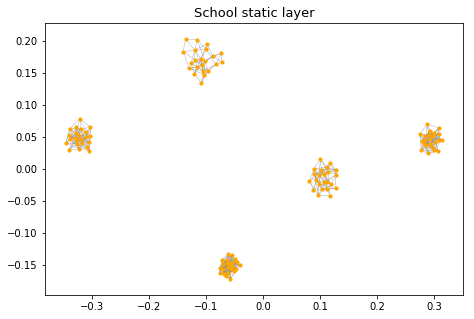

/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


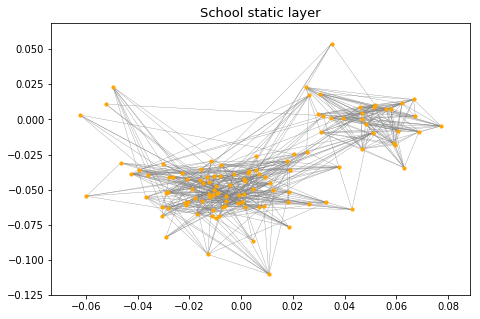

In [47]:
# Visualization of the layer with its proper graphical representation and with the global one

# clustered visualization
print_static_network(L_schools[0], remove_isolated = True, layer_name = 'School', node_color = 'orange', pos=None)

# global representation (common to all layers to be stakable)
print_static_network(L_schools[0], remove_isolated = True, layer_name = 'School', node_color = 'orange', pos=pos)

In [48]:
# append to L_Static

L_static.append(L_schools)

## Static layers

In [49]:
# functions to generate multiple SBM graphs given arrays of information

def create_multiple_SBM(layers, block_sizes = [], block_prob = [], seed_nb = 10, layers_name = None):    
    if layers_name is None:
        layers_name = ["Layer n. "+str(s+2) for s in range(layers)]
    L = []  
    for s in range(layers):                                                                    
        gt = nx.stochastic_block_model(block_sizes[s], block_prob[s], seed = seed_nb)
#         nx.draw_networkx(gt) 
#         plt.title(layers_name[s] +" with "+str( len(block_prob[s]))+" clusters")
#         plt.show() 
        n = len(gt)                                                         
        lt = nx.laplacian_matrix(gt,range(n))
        lt = np.array(lt.todense())                   # convert to non-sparse matrix
        L.append(lt)                                                     
    return L

### Household layer

This layer is created used the ISTAT data from: https://www.istat.it/it/archivio/196689
From which we calculated that, at jan 2020, the number of components for family in italy is:
- 1 component: 31.5 per cent
- 2 components: 27 per cent
- 3 components: 20 per cent
- 4 components: 16 per cent
- 5 components: 4.3 per cent
- 6+ components: 1.2 per cent

The approach is to overlap many "boolean" SBM with internal probability 1 and external probability 0 everywhere, to obtain clusters linked internally at maximum strenght but esternally unlinked. The overlapping is performed creating a block diagonal matrix from the single laplacian matrices. A shuffle of the nodes is performed via a random mapping, to ensure that the distribution of people varies respect other layers (jobs/schools).

In [50]:
# calculate clustering quantities (number of clusters, number of elements in each cluster)

components_list = np.array([1, 2, 3, 4, 5, 6]).astype(int)
components_percentages = [0.315, 0.27, 0.20, 0.16, 0.043, 0.012]
components_quantities = [int(round(N*x)) for x in components_percentages]
n_clusters = np.round(components_quantities/components_list).astype(int)


# adjust clusters quantities to be perfectly divisible 

diff = N - sum(n_clusters*components_list)
n_clusters[0] += diff
components_quantities = n_clusters*components_list


# print

for i in range(len(n_clusters)):
    print("Number of families with", components_list[i],"component: ", n_clusters[i])
print("tot:", sum(n_clusters*components_list))

Number of families with 1 component:  159
Number of families with 2 component:  68
Number of families with 3 component:  33
Number of families with 4 component:  20
Number of families with 5 component:  4
Number of families with 6 component:  1
tot: 500


In [51]:
# calculate boolean SBM for each kind of family (1,2,3,... components)

internal_probs = [1]*6
external_probs = [0]*6
blocks = create_equal_blocks(components_quantities, n_clusters, len(components_list))
probs = create_equal_probs(n_clusters, len(components_list), internal_probs, external_probs)

layers_name = ["Families with " + str(x) + " components" for x in components_list]
L_households_temp = create_multiple_SBM(layers = len(components_list),  block_sizes = blocks, block_prob = probs,  
                                       seed_nb = 10, layers_name = layers_name)

In [52]:
# block diagonal adjacency matrix

for i in range(len(L_households_temp)-1):
    if i==0:
        L_households = scipy.linalg.block_diag(L_households_temp[i], L_households_temp[i+1])
    else: 
        L_households = scipy.linalg.block_diag(L_households, L_households_temp[i+1])

In [53]:
# nodes shuffling

# create a random mapping
G_households = nx.from_numpy_matrix(-L_households + np.diag(np.diag(L_households)))
node_mapping = dict(zip(G_households.nodes(), sorted(G_households.nodes(), key=lambda k: random.random())))


# build a new graph applying the mapping
G_shuffled = nx.relabel_nodes(G_households, node_mapping)
L_households = nx.linalg.laplacianmatrix.laplacian_matrix(G_shuffled) #, nodelist=list(range(N)))   
L_households = np.array(L_households.todense())  

/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


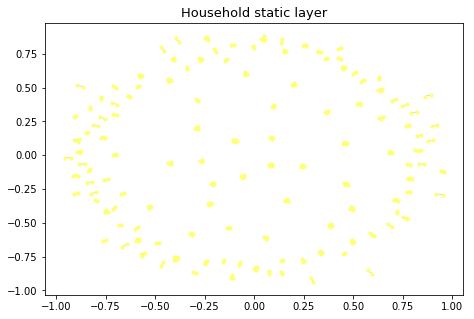

/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


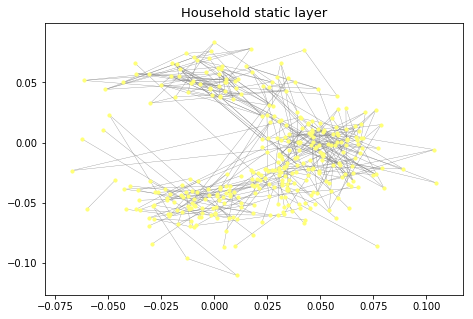

In [54]:
# Visualization of the layer with its proper graphical representation and with the global one

# clustered visualization
print_static_network(L_households, remove_isolated = True, layer_name = 'Household', node_color = '#FFFF77', pos=None)

# global representation (common to all layers to be stakable)
print_static_network(L_households, remove_isolated = True, layer_name = 'Household', node_color = '#FFFF77', pos=pos)

In [55]:
# append to L_static

L_static.append(L_households)

## Concatenate dynamic and static layers
L_dynamic is a 4 dimensional matrix with external size T, then S_dynamic and inside NxN matrices.
L_static doesn't have the temporal dimention, it's only a list of lenght S_static of NxN matrices.

In [56]:
# Creation of L as temporal snapshots given by both dynamic and static layers

L = [ [L_dynamic[s][t] for s in range(len(L_dynamic))] + [L_schools[t]] + [L_households] for t in range(T)]

In [57]:
print("L è una matrice 4-dim di taglia: " , len(L), " x ", len(L[0]), " x ", L[0][0].shape)

L è una matrice 4-dim di taglia:  28  x  5  x  (500, 500)


In [58]:
# check that L is long 5 at all timestamps:
for t in range(T):
    if  len(L[t]) != 5:
        print(t)

print("................")

# check that L is NxN at all timestamps and layers:
for t in range(T):
    for s in range(S):
        if L[t][s].shape[0] != N or L[t][s].shape[1] != N:
            print(t,s,L[t][s].shape)
            

................


In [59]:
# Save the multilayer dynamic network in a .npy file as 4D numpy array

np.save("datasets/outputs/multilayer_dynamic_network.npy", L)